In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler

import umap.umap_ as umap


In [ ]:
data_folder2 = "qws2"
data_folder1 = "qws1"
file_path2 = os.path.join(data_folder2, "qws2.txt")
file_path1 = os.path.join(data_folder1, "qws1.txt")
cleaned_file_path2 = os.path.join(data_folder2, "data.csv")
cleaned_file_path1 = os.path.join(data_folder1, "data1.csv")

In [ ]:
# Read the file, skipping lines that start with #
with open(file_path2, "r") as f:
    lines = [line.strip() for line in f if not line.startswith("#") and line.strip() != ""]

ori_df = pd.DataFrame(lines)

ori_df = ori_df[0].str.split(",", expand=True)

ori_df = ori_df.drop(columns=11)

ori_df.columns = ["Response Time", "Availability", "Throughput", "Successability", "Reliability", "Compliance", "Best Practices", "Latency", "Documentation", "Service Name", "WSDL Address"]

ori_df.head(100)
ori_df.to_csv(cleaned_file_path2)


with open(file_path1, "r") as f:
    lines = [line.strip() for line in f if not line.startswith("#") and line.strip() != ""]

ori_df = pd.DataFrame(lines)

ori_df = ori_df[0].str.split(",", expand=True)

ori_df.columns = ["Response Time", "Availability", "Throughput", "Successability", "Reliability", "Compliance", "Best Practices", "Latency", "Documentation", "WsRF", "Class", "Service Name", "WSDL Address"]

ori_df.head(100)
ori_df.to_csv(cleaned_file_path1)


 Format: QWS parameters are separated by commas (first nine)		##
 Format: (1) Response Time						##
 Format: (2) Availability						##
 Format: (3) Throughput						##
 Format: (4) Successability						##
 Format: (5) Reliability						##
 Format: (6) Compliance						##
 Format: (7) Best Practices						##
 Format: (8) Latency							##
 Format: (9) Documentation						##
 Format: (10) Service Name						##
 Format: (11) WSDL Address						##Documentation

In [ ]:
# Load data
df1 = pd.read_csv(cleaned_file_path1, index_col=0)  

df = df1
print(len(df))
df.head()

- Dtypes and Nulls

there are no empty values

In [ ]:
for col in df.columns:
    print(col)
    print(df[col].dtypes)
    print("Null:", df[col].isna().mean() * 100)
    print(df[col].unique())
    print('- - -')

- Histograms

In [ ]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 5))
    plt.hist(df[col])
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df[col])
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

- Outliers

In [ ]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 5))
    plt.boxplot(df[col])
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    filtered_df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

In [ ]:
filtered_df = df.iloc[:0].copy()#df.copy()
threshold = 3

for col in df.select_dtypes(include=['int64', 'float64']).columns:
    if col != 'Class':
        mean_val = df[col].mean()
        std_val = df[col].std()
        z_scores = (df[col] - mean_val) / std_val
        mask = z_scores.abs() < threshold
        filtered_df[col] = df[col].where(mask)

        median_val = df[col].median()  
        filtered_df[col].fillna(median_val, inplace=True)

In [ ]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 5))
    plt.boxplot([df[col], filtered_df[col]], labels=['Original', 'Filtered'])
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

- Encoding/Removing str columns

In [ ]:
encoded_df = filtered_df.copy() # does not have Service Name or Class

encoded_df['Class'] = df['Class']
encoded_df['Service Name'] = df['Service Name']

encoder = BinaryEncoder(cols=['Service Name'])
encoded_df = encoder.fit_transform(encoded_df)
encoded_df.drop(columns='WSDL Address', inplace=True)
encoded_df

- Correlation Matrix

Higher correlation between: Response Time / Latency; Successability / Availability; Class / WsRF
Low correlation of Service Name_5, 6, 7, 8

In [ ]:
corr_matrix = encoded_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
ratio_df = encoded_df.drop(columns=['Service Name_4','Service Name_5', 'Service Name_6', 'Service Name_7', 'Service Name_8'])

- Study ration columns

In [ ]:
ratio_df['Latency_ResponseTime'] = ratio_df['Response Time'] / ratio_df['Latency']
ratio_df['Availability_Successability'] = ratio_df['Availability'] / ratio_df['Successability']
ratio_df['Class_Wsrf'] = ratio_df['Class'] / ratio_df['WsRF']

In [ ]:
for col in ['Latency_ResponseTime', 'Availability_Successability', 'Class_Wsrf']:

    plt.figure(figsize=(10, 5))
    plt.plot(ratio_df[col])
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

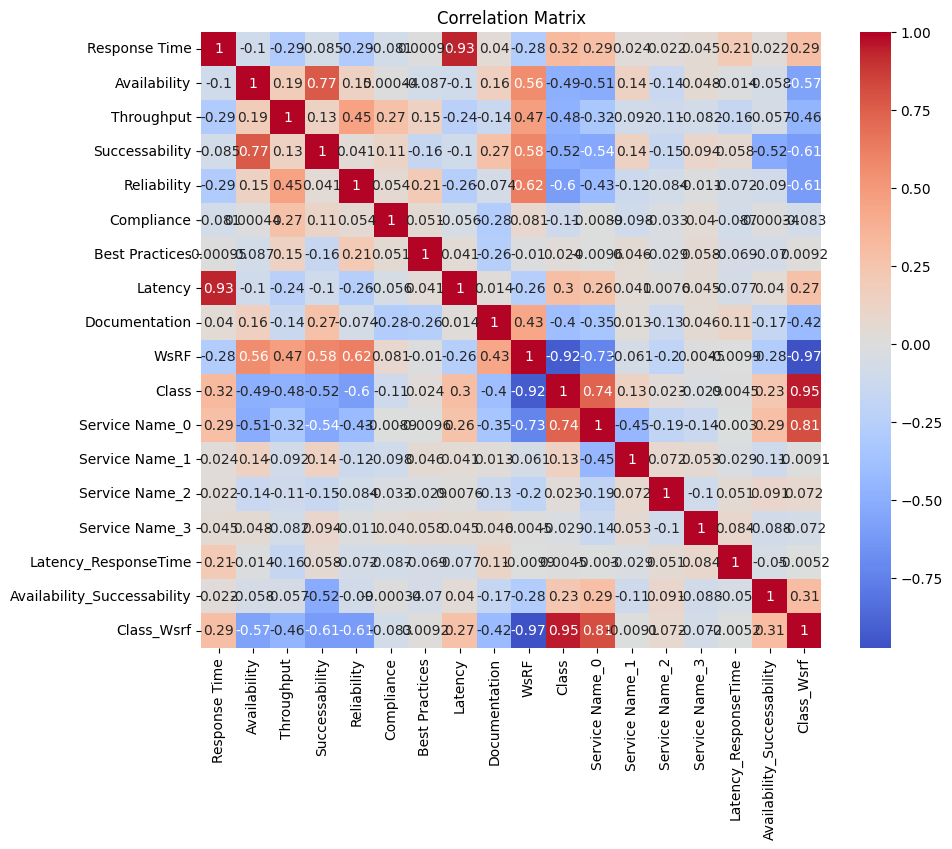

In [93]:
corr_matrix = ratio_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


- Normalize data

In [ ]:
scaled_df = encoded_df

scaler = StandardScaler()

for col in scaled_df.columns:
    if col != 'Class':
        scaled_df[col] = scaler.fit_transform(scaled_df[[col]])  
        print(scaled_df[col].min(), scaled_df[col].max())

scaled_df

- Dimentionality Reduction

In [ ]:
X = scaled_df.drop(columns=['Class'])
Y = scaled_df['Class']

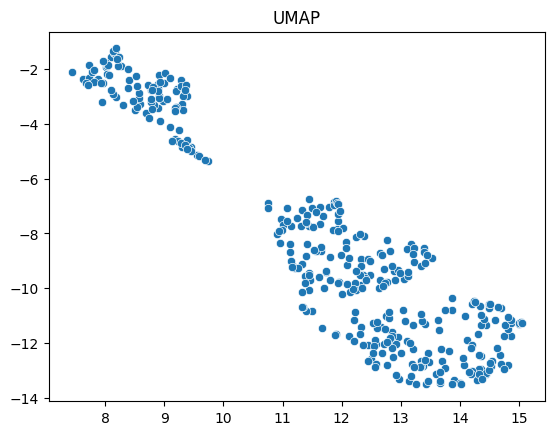

In [91]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1])
plt.title("UMAP")
plt.show()

# Save

In [92]:
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['label'] = Y

scaled_df.to_csv('processed_data.csv',index=False)
df_umap.to_csv('data_umap.csv', index=False)

# References

Dimentionality reduction: 


https://medium.com/@adnan.mazraeh1993/a-comprehensive-guide-to-dimensionality-reduction-from-basic-to-super-advanced-techniques-19-c63858266cbd
https://medium.com/@laakhanbukkawar/pca-vs-t-sne-vs-umap-visualizing-the-invisible-in-your-data-92cb2baebdbb